## Transformer

### Multi-head-attention
> 多头注意力
- **多头注意力**：序列中每一个token被映射为长度为d的向量，可以把d看成CNN里面的多通道的通道
- 对于同一个query，key，value，我们希望抽取不同的信息，例如短距离关系和长距离关系
- 多头注意力使用$h$个独立的注意力头，把QKV使用一个全连接层投影到低维度，然后合并$h$个不同的头的输出拼接得到最终结果
- **每个头都可能会关注输入的不同部分， 可以表示比简单加权平均值更复杂的函数**
<img src='../images/68image1.png' width='500'>

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def transpose_qkv(X, num_heads):
    """
    为了多头注意力的并行计算而改变形状
    X[bs, n_q/ n_kv, num_hiddens]
    """
    # [bs, n_q or n_kv, num_heads, num_hiddens/num_heads]
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # [bs, num_heads, n_q or n_kv, num_hiddens/num_heads]
    X = X.permute(0, 2, 1, 3)

    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """
    X [bs * num_heads, n_q, num_hiddens / num_heads]
    """
    # [bs, num_heads, n_q, num_hiddens / num_heads]
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    # [bs, n_q, num_heads, num_hiddens / num_heads]
    X = X.permute(0, 2, 1, 3)
    # [bs, n_q, num_hiddens]
    return X.reshape(X.shape[0], X.shape[1], -1)


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self,queries, keys, values, valid_lens):
        """
        queries [bs, n_q, d_q]
        keys [bs, n_kv, d_k]
        values [bs, n_kv, d_v]
        valid_lens [bs,] or [bs, n_q]
        """
        # 这里尽量不使用for loop计算，而是使用矩阵乘法进行计算
        # 提高并行度，提高程序运行效率, 使用矩阵乘法把头这个维度放到前面
        # 否则就要一个头一个头的算
        # [bs*num_heads, n_q or n_kv, num_hiddens/ num_heads]
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, self.num_heads, dim=0)
        
        # [bs * num_heads, n_q, num_hiddens / num_heads]
        # 经过变换这里只需要做一次点积注意力就可以实现多头注意力的操作
        # 如果不经过变换，那么每个头都要单独做一次，降低了程序的并行度
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        # [bs, n_q, num_hiddens]
        return self.W_o(output_concat)

In [5]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [6]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

### Masked Multi-head attention
> 掩码多头注意力
- 在decoder中，对序列中元素做预测的时候，我们不应该考虑之后的元素
- 可以通过掩码来实现
  - 计算$\mathbf{x}_i$的输出的时候，假装当前的序列只有$i$

### PositionWise FFN(Feed forward Network)
>基于位置的前馈网络
- 模型的输入是$[b, n, d]$，其中b是句子数（batch_size），n是一句话中词的个数，d是模型维度，但是n的长度是可变的，我们的模型应该能够处理任意长度的序列才对，所以我们要进行一定的变换
- 将输入维度转成$[bn, d]$，把单个序列元素$\mathbf{x}_i$当作是一个样本，而不是把一个句子当成一个样本，然后再reshape成$[b,n,d']$
- 等价于两层核窗口为1的一维卷积层

### Layer Normalization
>层归一化
- `Batch Norm`是对样本的特征/通道做归一化，所以在处理序列模型的时候，也就是在d这个维度上进行归一化
  - 但是由于在`NLP/序列模型`中会进行padding，变长的序列会产生很多padding的0，会导致不稳定
- 所以在这里我们使用层归一化，对batch中每个样本做归一化
- BN类似于算全年级单科平均分，LN类似于算一个班总分的平均分


<img src='../images/68image2.png' width='500'>

### 信息传递
- 编码器的输出$\mathbf{y}_1, ..., \mathbf{y}_n$
- 将其作为transformer第i个解码器中多头注意力的key 和 value
  - 它的query来自目标序列
- 这意味着encoder和decoder中块的个数和输出维度都是一样的

### Prediction
> 预测
- 在预测第$t + 1$个输出的时候
- 我们已经得到了前$t$个预测值
- 在自注意力中，我们得到的前$t$个预测值作为key和value，第$t$个预测值作为query
<img src='../images/68image3.png' width='500'>

In [7]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

<img src='../images/68image4.png' width='400'>

In [8]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        """
        X [bs, n_q or n(seq len), num_hiddens]
        """
        return self.dense2(self.relu(self.dense1(X)))

In [9]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

- 残差连接和规范化

In [10]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor(
    [[1, 2], 
     [2, 3]], 
    dtype=torch.float32
    )
print("Layer Norm:", ln(X), "\nBatch Norm:", bn(X))

Layer Norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
Batch Norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [11]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)



In [12]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones(2, 3, 4), torch.ones(2, 3, 4)).shape


torch.Size([2, 3, 4])

### TransformerEncoderBlock

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads,
                                                dropout, bias=use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [14]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

### TransformerEncoder

In [15]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                 dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                f"blk_{i}",
                EncoderBlock(key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens, 
                             num_heads, dropout, use_bias=use_bias)
            )
    def forward(self, X, valid_lens, *args):
        """
        X [bs, num_steps(seq_len)]
        valid_lens [bs] or [bs, n_q]
        """
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [16]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long),valid_lens).shape

torch.Size([2, 100, 24])

### TransformerDecoderLayer

In [17]:
class DecoderBlock(nn.Module):
    """decoder中的第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        if state[2][self.i] is None:
            # 如果是训练阶段， 输出序列的所有token都在同一次前向中处理
            # state[2]是一个列表，存的是第i个decoder block对于当前词的输出表示
            # 如果是训练阶段，前向一次，那么state[2]就全是None
            # 如果是预测阶段，词是一个一个生成的，
            # state[2]中就不是None
            key_values = X
        else:
            # X表示上一个时刻的输出值[1, 1, num_hiddens]
            # state[2][self.i]表示第i个块在前向过程中之前所有的词的表示，逐个concatenate到一起
            key_values = torch.cat((state[2][self.i], X), dim=1)
        # 更新state[2][self.i]
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [18]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

### TransformerDecoder

In [19]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                f"blk_{i}",
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i)
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        """
        X [bs, num_steps]
        """
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### 训练

loss 0.030, 6570.7 tokens/sec on cuda:0


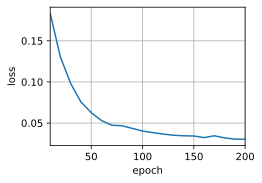

In [20]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}\t ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !	  bleu 1.000
i lost . => j'ai perdu .	  bleu 1.000
he's calm . => il est calme .	  bleu 1.000
i'm home . => je suis chez moi .	  bleu 1.000


- 可视化最后一个翻译任务的权重
- 编码器的注意力权重为[num_layers, bs(1) * num_heads, n_q, n_kv]

In [22]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

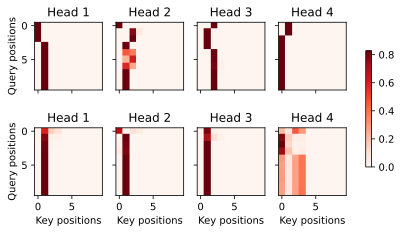

In [23]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

- 可视化编码器自注意力以及“encoder-decoder”的注意力权重

In [24]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn
                            for head in blk]
len(dec_attention_weight_seq)

6

In [ ]:
# decoder中的两个注意力             每个注意力类型中有两个层
len(dec_attention_weight_seq[0]), len(dec_attention_weight_seq[0][0])

(2, 2)

In [30]:
# 第一步预测时的self-attention的第1层的注意力矩阵，多头注意力返回的注意力矩阵的形状是[bs * num_heads, n_q, n_k]
dec_attention_weight_seq[0][0][0].shape, dec_attention_weight_seq[0][0][0][0].tolist()

(torch.Size([4, 1, 1]), [[1.0]])

In [ ]:
import pandas as pd
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values
)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
# [num_layers, num_heads, n_q, num_stpes]
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

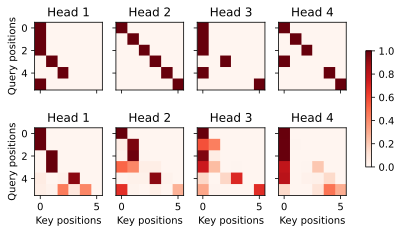

In [33]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

- 由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。

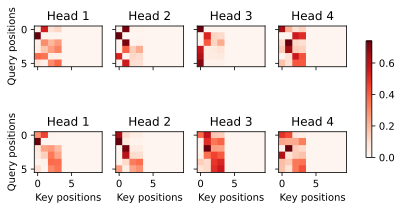

In [34]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))